Sistema de ML da OpenAI para geração de imagens através de pontos.

Fonte: https://openai.com/research/point-e

A versão do six do colab é anterior a versão necessária, logo precisa atualizar.

In [ ]:
# versão do six necessária para utilização do point-e
!pip install six --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Instala o point-e da OpenAI

Fonte: https://github.com/openai/point-e/issues/16

Fonte do código: https://github.com/openai/point-e/blob/main/point_e/examples/text2pointcloud.ipynb

In [ ]:
# instalação do point-e
!pip install git+https://github.com/openai/point-e.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/point-e.git to /tmp/pip-req-build-t1yxfp2l
  Running command git clone --filter=blob:none --quiet https://github.com/openai/point-e.git /tmp/pip-req-build-t1yxfp2l
  Resolved https://github.com/openai/point-e.git to commit fc8a607c08a3ea804cc82bf1ef8628f88a3a5d2f
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-install-caejcf0_/clip_d637878c3fd04fb5926dd6104102ef34
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-install-caejcf0_/clip_d637878c3fd04fb5926dd6104102ef34
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Importa as bibliotecas necessárias

In [ ]:
# import das bibliotecas necessárias
import torch
from tqdm.auto import tqdm

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

Configura o dispositivo

In [ ]:
# configuração do dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M-textvec'
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...


100%|████████████████████████████████████████| 890M/890M [00:06<00:00, 144MiB/s]


creating upsample model...
downloading base checkpoint...


  0%|          | 0.00/161M [00:00<?, ?iB/s]

downloading upsampler checkpoint...


  0%|          | 0.00/162M [00:00<?, ?iB/s]

<All keys matched successfully>

Configura o sampler

In [ ]:
# configuração do sampler
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 0.0],
    model_kwargs_key_filter=('texts', ''), # Do not condition the upsampler at all
)

Recebe o prompt e cria a estrutura do objeto de acordo com o prompt

In [ ]:
# recebe o prompt para a geração da imagem
prompt = 'a red motorcycle'

# produz o modelo com base no prompt fornecido
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(texts=[prompt]))):
    samples = x

0it [00:00, ?it/s]

Renderiza o prompt

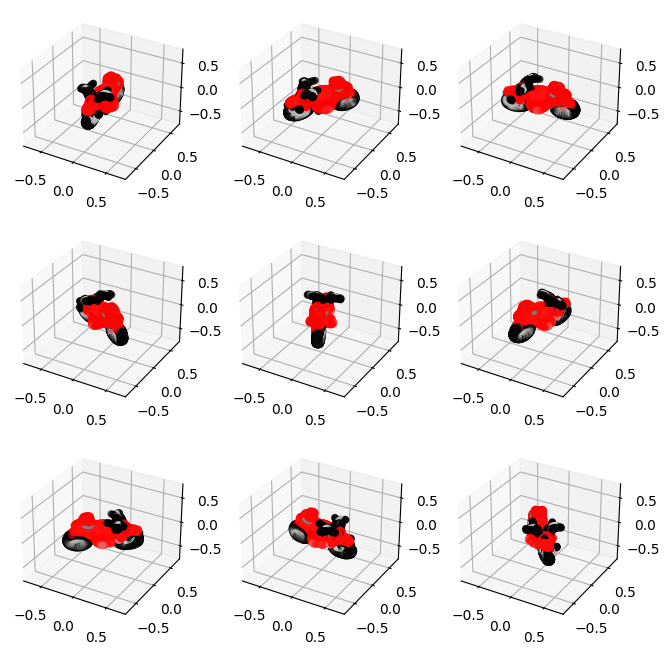

In [ ]:
# renderiza o prompt no colab
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))